# Pricing Experimentation: Un Enfoque Causal

---

## Pregunta Causal Central

> **¿Cuánto cambió el consumo de reservas en los mercados donde aumentamos el precio +5%/+10%/+15%, comparado con lo que hubiera ocurrido si no hubiéramos cambiado el precio?**

Este notebook implementa un análisis causal riguroso para estimar el efecto de cambios de precio sobre las reservas (bookings) utilizando **Synthetic Control Method (SCM)**.

### Referencias Metodológicas

- **Hernán & Robins** - *Causal Inference: What If* (2020)
- **Abadie, Diamond & Hainmueller** - *Synthetic Control Methods* (2010)
- **Abadie** - *Using Synthetic Controls* (2021)
- **Matheus Facure** - *Causal Inference for the Brave and True*

---

## 1. El Problema: A/B Testing e Inferencia Causal

### 1.1 Por qué A/B Testing falla en pricing

**Interferencia entre usuarios (violación de SUTVA)**

Los usuarios comparan precios entre sí. Las reseñas y el word-of-mouth propagan información de precios. El tratamiento de un usuario afecta el outcome de otros.

**Riesgo reputacional y discriminación percibida**

Mostrar precios diferentes a usuarios similares genera desconfianza. El price discrimination percibido daña la marca. Efectos de largo plazo no capturados en experimentos cortos.

**El precio es una policy, no un feature aislado**

Un feature se puede activar/desactivar por usuario. El precio es una decisión de negocio que aplica a todo un mercado. La unidad natural de experimentación es el **mercado geográfico**.

### 1.2 Conclusión: quasi-experimentos a nivel de mercado

Necesitamos quasi-experimentos donde algunos mercados reciben el tratamiento (aumento de precio), otros sirven como control, y estimamos el contrafactual mediante Synthetic Control.

---

## 2. La Pregunta y el Target Trial

### 2.1 Target Trial: qué experimento estamos emulando

Siguiendo el framework de Hernán & Robins (Cap. 3), definimos el ensayo ideal:

| Componente | Especificación |
|------------|----------------|
| **Eligibility** | Mercados europeos con >50 bookings/día, sin promociones activas |
| **Treatment strategy** | Asignación Control, +5%, +10%, +15% |
| **Assignment** | Aleatorio a nivel de mercado |
| **Outcome** | Bookings diarios |
| **Start/End of follow-up** | Día de implementación / +45 días |
| **Causal contrast** | ATT por brazo vs control |

### 2.2 El DAG: Z → P → Y

```
       Z (Policy)              FX
    +5%|+10%|+15%|Ctrl          |
           |                    |
           v      First stage   v
           P (Precio PVP efectivo)
           |
           | Elasticidad
           v
           Y (Bookings) <------ Marketing, GDP, Seasonality
           ^
           |
           U (No observable: Competencia, Marca)
```

**Puntos clave:**
- El treatment es la **policy (Z)**, no el precio (P)
- El precio es un **mediador** entre Z e Y
- FX afecta al precio efectivo pero no es confusor de Z→Y
- U (Competencia, Marca) es confusor no observable - justifica usar SCM

### 2.3 Estimand: ATT por brazo

Average Treatment Effect on the Treated:

```
ATT_5%  = E[Y(1) - Y(0) | Z = +5%]
ATT_10% = E[Y(1) - Y(0) | Z = +10%]
ATT_15% = E[Y(1) - Y(0) | Z = +15%]
```

Todos comparados contra el mismo pool de control.

---

## 3. Asunciones de Identificación para SCM

### 3.1 No Anticipation

No hay efectos del tratamiento antes de su implementación. Los mercados no ajustan comportamiento anticipando el cambio de precio. **Verificación**: inspección visual del pre-periodo, conocimiento del negocio.

### 3.2 Convex Hull (Aproximabilidad)

El mercado tratado puede representarse como una combinación convexa de mercados de control. **Verificación**: RMSPE bajo en pre-periodo indica que el sintético replica bien al tratado.

### 3.3 Estabilidad Temporal

La relación entre el tratado y los controles que funciona en pre-periodo sigue siendo válida en post-periodo. No hay shocks estructurales que afecten diferencialmente al tratado.

### 3.4 Consistency (Intervención bien definida)

La intervención debe estar bien definida: "+X% sobre PVP inicial, sin tasas adicionales, ventana limpia sin promociones".

### 3.5 SUTVA (No interferencia entre mercados)

Los mercados no interfieren entre sí. **Verificación**: tráfico cruzado mínimo, monedas distintas.

---

**Nota importante**: A diferencia de DiD, SCM **no requiere parallel trends**. SCM es más flexible porque construye el contrafactual como combinación ponderada optimizada, no asume que tratado y control tendrían la misma pendiente. La validación se hace verificando el ajuste en pre-periodo (RMSPE).

---

## 4. Setup: Instalación y Carga de Datos

In [1]:
# Instalación de dependencias (descomentar en Colab)
# !pip install -q pandas numpy matplotlib seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fmin_slsqp
from functools import partial
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [3]:
# Cargar datos desde local (Colab)
from google.colab import files
import io

# Subir archivo - selecciona 'pricing_experiment_data.csv'
print("Selecciona el archivo pricing_experiment_data.csv:")
uploaded = files.upload()

# Cargar el CSV
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print(f"\nDataset: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Periodo: {df['date'].min()} a {df['date'].max()}")
print(f"Mercados: {df['market'].unique()}")
print(f"Brazos de tratamiento: {df['treatment_arm'].unique()}")

Selecciona el archivo pricing_experiment_data.csv:


Saving dataset pricing.csv to dataset pricing.csv

Dataset: 1800 filas, 25 columnas
Periodo: 2024-01-01 a 2024-05-29
Mercados: ['AT' 'BE' 'CH' 'DE' 'ES' 'FR' 'IT' 'MX' 'NL' 'PL' 'PT' 'UK']
Brazos de tratamiento: ['control' '+10%' '+5%' '+15%']


In [4]:
# Estructura de mercados y tratamientos
market_summary = df.groupby(['market', 'treatment_arm']).agg({
    'treatment_start_day': 'first',
    'wave': 'first',
    'bookings': 'mean'
}).reset_index()

print("Estructura del experimento:")
print(market_summary.to_string(index=False))

Estructura del experimento:
market treatment_arm  treatment_start_day  wave   bookings
    AT       control                    0     0 129.206667
    BE       control                    0     0 162.086667
    CH          +10%                  106     2 187.906667
    DE       control                    0     0 548.400000
    ES           +5%                   91     1 436.333333
    FR       control                    0     0 492.793333
    IT           +5%                   91     1 410.080000
    MX          +15%                  121     3 212.946667
    NL       control                    0     0 217.226667
    PL          +10%                  106     2 173.066667
    PT          +15%                  121     3 150.406667
    UK          +10%                  106     2 522.180000


---

## 5. El Diseño del Experimento

### 5.1 Definición operativa del treatment (Consistency)

- **+X% sobre PVP inicial**: sin tasas adicionales
- **Ventana limpia**: sin promociones ni cupones activos
- **Múltiples brazos** para estimar curva: +5%, +10%, +15% vs control

### 5.2 Selección de mercados

**Donor Pool (Control):** AT, BE, DE, FR, NL - 5 mercados que nunca reciben tratamiento

**Mercados Tratados:**
- Wave 1 (+5%): ES, IT - día 91
- Wave 2 (+10%): CH, PL, UK - día 106  
- Wave 3 (+15%): MX, PT - día 121

### 5.3 Selección de mercados representativos para SCM

Seleccionamos UN mercado por brazo para el análisis SCM detallado:
- **ES** para +5% (mercado grande, eurozona)
- **UK** para +10% (mercado grande, fuera eurozona)
- **PT** para +15% (mercado mediano, eurozona)

In [5]:
# Definir estructura del experimento
CONTROL_MARKETS = ['AT', 'BE', 'DE', 'FR', 'NL']

TREATED_MARKETS = {
    '+5%': {'markets': ['ES', 'IT'], 'representative': 'ES', 'treatment_day': 91},
    '+10%': {'markets': ['CH', 'PL', 'UK'], 'representative': 'UK', 'treatment_day': 106},
    '+15%': {'markets': ['MX', 'PT'], 'representative': 'PT', 'treatment_day': 121}
}

print("Donor Pool (Control):")
for m in CONTROL_MARKETS:
    avg_bookings = df[df['market'] == m]['bookings'].mean()
    print(f"  {m}: {avg_bookings:.0f} bookings/día promedio")

print("\nMercados Tratados (representativo para SCM):")
for arm, info in TREATED_MARKETS.items():
    rep = info['representative']
    avg_bookings = df[df['market'] == rep]['bookings'].mean()
    print(f"  {arm}: {rep} - {avg_bookings:.0f} bookings/día - tratamiento día {info['treatment_day']}")

Donor Pool (Control):
  AT: 129 bookings/día promedio
  BE: 162 bookings/día promedio
  DE: 548 bookings/día promedio
  FR: 493 bookings/día promedio
  NL: 217 bookings/día promedio

Mercados Tratados (representativo para SCM):
  +5%: ES - 436 bookings/día - tratamiento día 91
  +10%: UK - 522 bookings/día - tratamiento día 106
  +15%: PT - 150 bookings/día - tratamiento día 121


---

## 6. Exploración de Datos y Verificación de First Stage

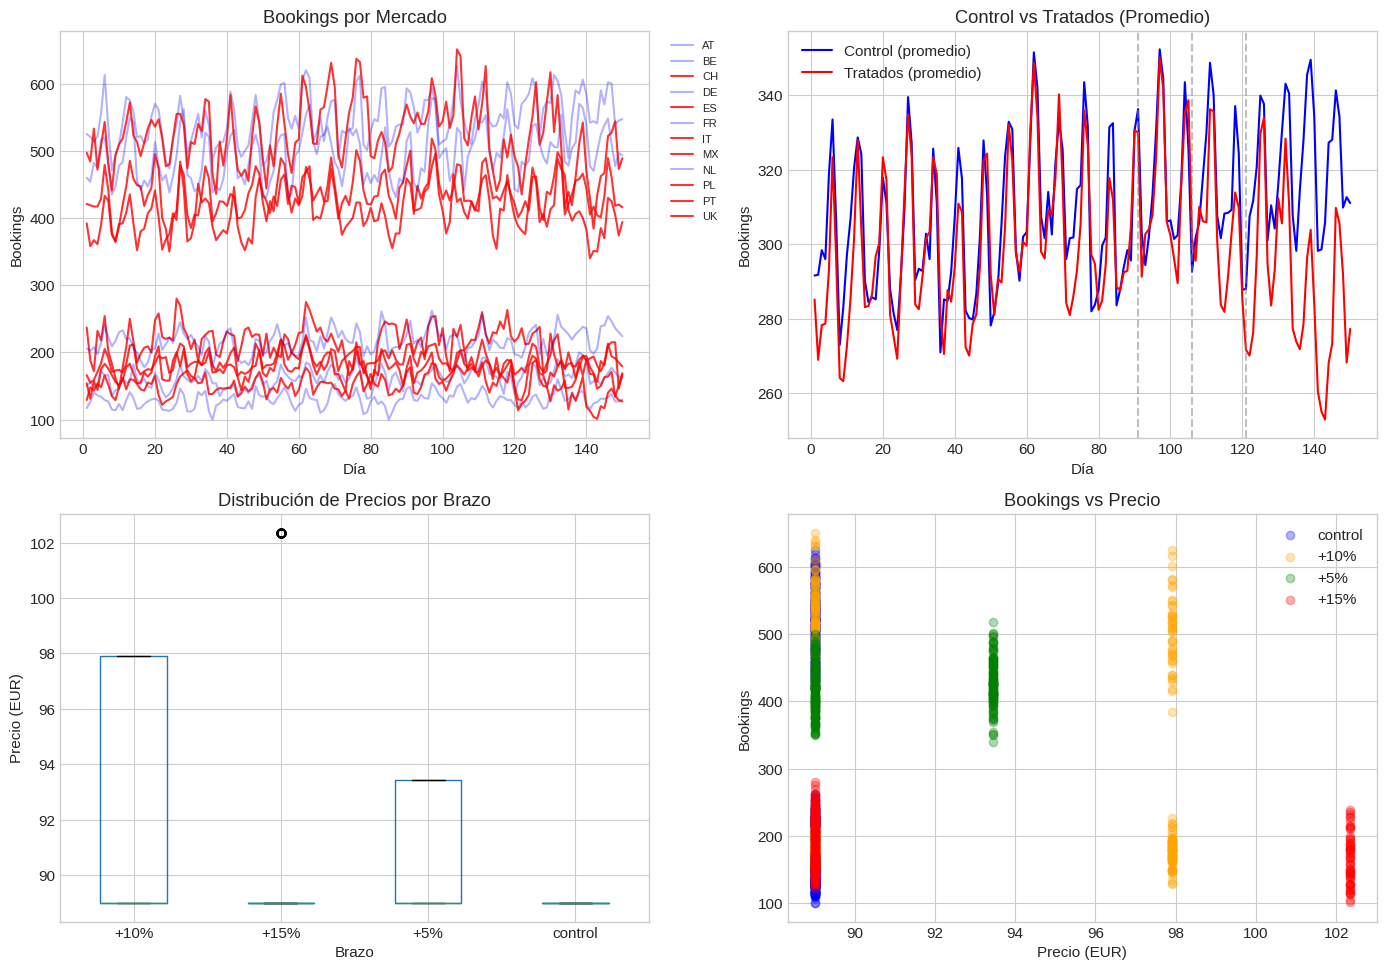

In [6]:
# Visualización: Series temporales por mercado
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Todos los mercados
ax = axes[0, 0]
for market in df['market'].unique():
    market_data = df[df['market'] == market]
    color = 'blue' if market in CONTROL_MARKETS else 'red'
    alpha = 0.3 if market in CONTROL_MARKETS else 0.8
    ax.plot(market_data['day_index'], market_data['bookings'],
            label=market, color=color, alpha=alpha)
ax.set_title('Bookings por Mercado')
ax.set_xlabel('Día')
ax.set_ylabel('Bookings')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)

# Panel 2: Control vs Tratados agregados
ax = axes[0, 1]
control_avg = df[df['market'].isin(CONTROL_MARKETS)].groupby('day_index')['bookings'].mean()
treated_avg = df[~df['market'].isin(CONTROL_MARKETS)].groupby('day_index')['bookings'].mean()
ax.plot(control_avg.index, control_avg.values, label='Control (promedio)', color='blue')
ax.plot(treated_avg.index, treated_avg.values, label='Tratados (promedio)', color='red')
for arm, info in TREATED_MARKETS.items():
    ax.axvline(x=info['treatment_day'], color='gray', linestyle='--', alpha=0.5)
ax.set_title('Control vs Tratados (Promedio)')
ax.set_xlabel('Día')
ax.set_ylabel('Bookings')
ax.legend()

# Panel 3: Distribución de precios por brazo
ax = axes[1, 0]
df.boxplot(column='price_eur', by='treatment_arm', ax=ax)
ax.set_title('Distribución de Precios por Brazo')
ax.set_xlabel('Brazo')
ax.set_ylabel('Precio (EUR)')
plt.suptitle('')

# Panel 4: Bookings vs Precio
ax = axes[1, 1]
colors = {'control': 'blue', '+5%': 'green', '+10%': 'orange', '+15%': 'red'}
for arm in df['treatment_arm'].unique():
    arm_data = df[df['treatment_arm'] == arm]
    ax.scatter(arm_data['price_eur'], arm_data['bookings'],
               alpha=0.3, label=arm, color=colors.get(arm, 'gray'))
ax.set_title('Bookings vs Precio')
ax.set_xlabel('Precio (EUR)')
ax.set_ylabel('Bookings')
ax.legend()

plt.tight_layout()
plt.show()

In [7]:
# Verificar First Stage: La policy (Z) realmente movió el precio (P)?
print("VERIFICACIÓN FIRST STAGE: Z → P")
print("="*50)

for arm, info in TREATED_MARKETS.items():
    rep = info['representative']
    t_day = info['treatment_day']

    market_data = df[df['market'] == rep]

    pre_price = market_data[market_data['day_index'] < t_day]['price_eur'].mean()
    post_price = market_data[market_data['day_index'] >= t_day]['price_eur'].mean()
    actual_uplift = (post_price - pre_price) / pre_price * 100

    nominal_uplift = float(arm.replace('%', '').replace('+', ''))

    print(f"\n{rep} ({arm}):")
    print(f"  Precio pre:  {pre_price:.2f} EUR")
    print(f"  Precio post: {post_price:.2f} EUR")
    print(f"  Uplift nominal: {nominal_uplift:.1f}%")
    print(f"  Uplift realizado: {actual_uplift:.1f}%")
    print(f"  Compliance: {'✓ OK' if abs(actual_uplift - nominal_uplift) < 2 else '⚠️ REVISAR'}")

VERIFICACIÓN FIRST STAGE: Z → P

ES (+5%):
  Precio pre:  89.00 EUR
  Precio post: 93.45 EUR
  Uplift nominal: 5.0%
  Uplift realizado: 5.0%
  Compliance: ✓ OK

UK (+10%):
  Precio pre:  89.00 EUR
  Precio post: 97.90 EUR
  Uplift nominal: 10.0%
  Uplift realizado: 10.0%
  Compliance: ✓ OK

PT (+15%):
  Precio pre:  89.00 EUR
  Precio post: 102.35 EUR
  Uplift nominal: 15.0%
  Uplift realizado: 15.0%
  Compliance: ✓ OK


---

## 7. Metodología: Synthetic Control Method

### 7.1 Intuición

El SCM construye un "clon" del mercado tratado usando una combinación ponderada de mercados de control. Los pesos se optimizan para minimizar la diferencia en el pre-periodo.

### 7.2 Formalización

Minimizamos:

```
min_W ||Y_treated_pre - Y_controls_pre · W||²
```

sujeto a: `sum(W) = 1`, `W >= 0`

El contrafactual post-tratamiento es: `Y_synthetic_post = Y_controls_post · W`

### 7.3 Diagnóstico clave: RMSPE pre-periodo

```
RMSPE = sqrt(mean((Y_treated - Y_synthetic)²)) en pre-periodo
```

Un RMSPE bajo indica buen ajuste y valida la asunción de aproximabilidad (convex hull).

In [8]:
def loss_w(w, X, y):
    """Función de pérdida: RMSPE entre tratado y sintético."""
    return np.sqrt(np.mean((y - X.dot(w))**2))

def get_synthetic_weights(X, y):
    """
    Obtiene los pesos óptimos para el control sintético.
    """
    n_controls = X.shape[1]
    w_start = np.array([1/n_controls] * n_controls)

    weights = fmin_slsqp(
        partial(loss_w, X=X, y=y),
        w_start,
        f_eqcons=lambda w: np.sum(w) - 1,
        bounds=[(0.0, 1.0)] * n_controls,
        disp=False
    )

    return weights

def diagnose_positivity(weights, control_markets):
    """Diagnóstico de Positivity: verifica que los pesos no estén degenerados."""
    effective_donors = sum(1 for w in weights if w > 0.05)
    hhi = sum(w**2 for w in weights)
    max_weight = max(weights)

    return {
        'effective_donors': effective_donors,
        'total_donors': len(weights),
        'hhi': hhi,
        'max_weight': max_weight,
        'positivity_ok': effective_donors >= 2 and max_weight < 0.9
    }

def compute_synthetic_control(df, treated_market, control_markets, treatment_day, outcome='bookings'):
    """
    Construye el control sintético para un mercado tratado.
    """
    all_markets = [treated_market] + control_markets

    wide = df[df['market'].isin(all_markets)].pivot(
        index='day_index',
        columns='market',
        values=outcome
    )

    pre_data = wide[wide.index < treatment_day]
    y_pre = pre_data[treated_market].values
    X_pre = pre_data[control_markets].values

    weights = get_synthetic_weights(X_pre, y_pre)
    positivity_diag = diagnose_positivity(weights, control_markets)

    X_full = wide[control_markets].values
    synthetic_series = X_full.dot(weights)
    treated_series = wide[treated_market].values
    effect_series = treated_series - synthetic_series

    pre_effect = effect_series[:treatment_day-1]
    rmspe_pre = np.sqrt(np.mean(pre_effect**2))
    day_index = wide.index.values

    return {
        'weights': dict(zip(control_markets, weights)),
        'synthetic': synthetic_series,
        'treated': treated_series,
        'effect': effect_series,
        'day_index': day_index,
        'treatment_day': treatment_day,
        'rmspe_pre': rmspe_pre,
        'market': treated_market,
        'positivity': positivity_diag
    }

print("Funciones de Synthetic Control definidas.")

Funciones de Synthetic Control definidas.


---

## 8. SCM para cada Brazo de Tratamiento

In [9]:
# Calcular SCM para cada mercado representativo
results = {}

for arm, info in TREATED_MARKETS.items():
    rep = info['representative']
    t_day = info['treatment_day']

    print(f"\nCalculando SCM para {rep} ({arm})...")

    scm = compute_synthetic_control(
        df=df,
        treated_market=rep,
        control_markets=CONTROL_MARKETS,
        treatment_day=t_day
    )

    results[arm] = scm

    print(f"  RMSPE pre-periodo: {scm['rmspe_pre']:.2f}")
    print(f"  Pesos del sintético:")
    for market, weight in scm['weights'].items():
        if weight > 0.01:
            print(f"    {market}: {weight:.3f}")

    pos = scm['positivity']
    print(f"  Diagnóstico Positivity:")
    print(f"    Donors efectivos: {pos['effective_donors']}/{pos['total_donors']}")
    print(f"    HHI (concentración): {pos['hhi']:.3f} {'✓' if pos['hhi'] < 0.5 else '⚠️ Alta concentración'}")


Calculando SCM para ES (+5%)...
  RMSPE pre-periodo: 18.39
  Pesos del sintético:
    AT: 0.167
    BE: 0.069
    DE: 0.565
    FR: 0.199
  Diagnóstico Positivity:
    Donors efectivos: 4/5
    HHI (concentración): 0.391 ✓

Calculando SCM para UK (+10%)...
  RMSPE pre-periodo: 31.48
  Pesos del sintético:
    DE: 0.745
    FR: 0.255
  Diagnóstico Positivity:
    Donors efectivos: 2/5
    HHI (concentración): 0.620 ⚠️ Alta concentración

Calculando SCM para PT (+15%)...
  RMSPE pre-periodo: 11.21
  Pesos del sintético:
    AT: 0.517
    BE: 0.404
    FR: 0.020
    NL: 0.058
  Diagnóstico Positivity:
    Donors efectivos: 3/5
    HHI (concentración): 0.435 ✓


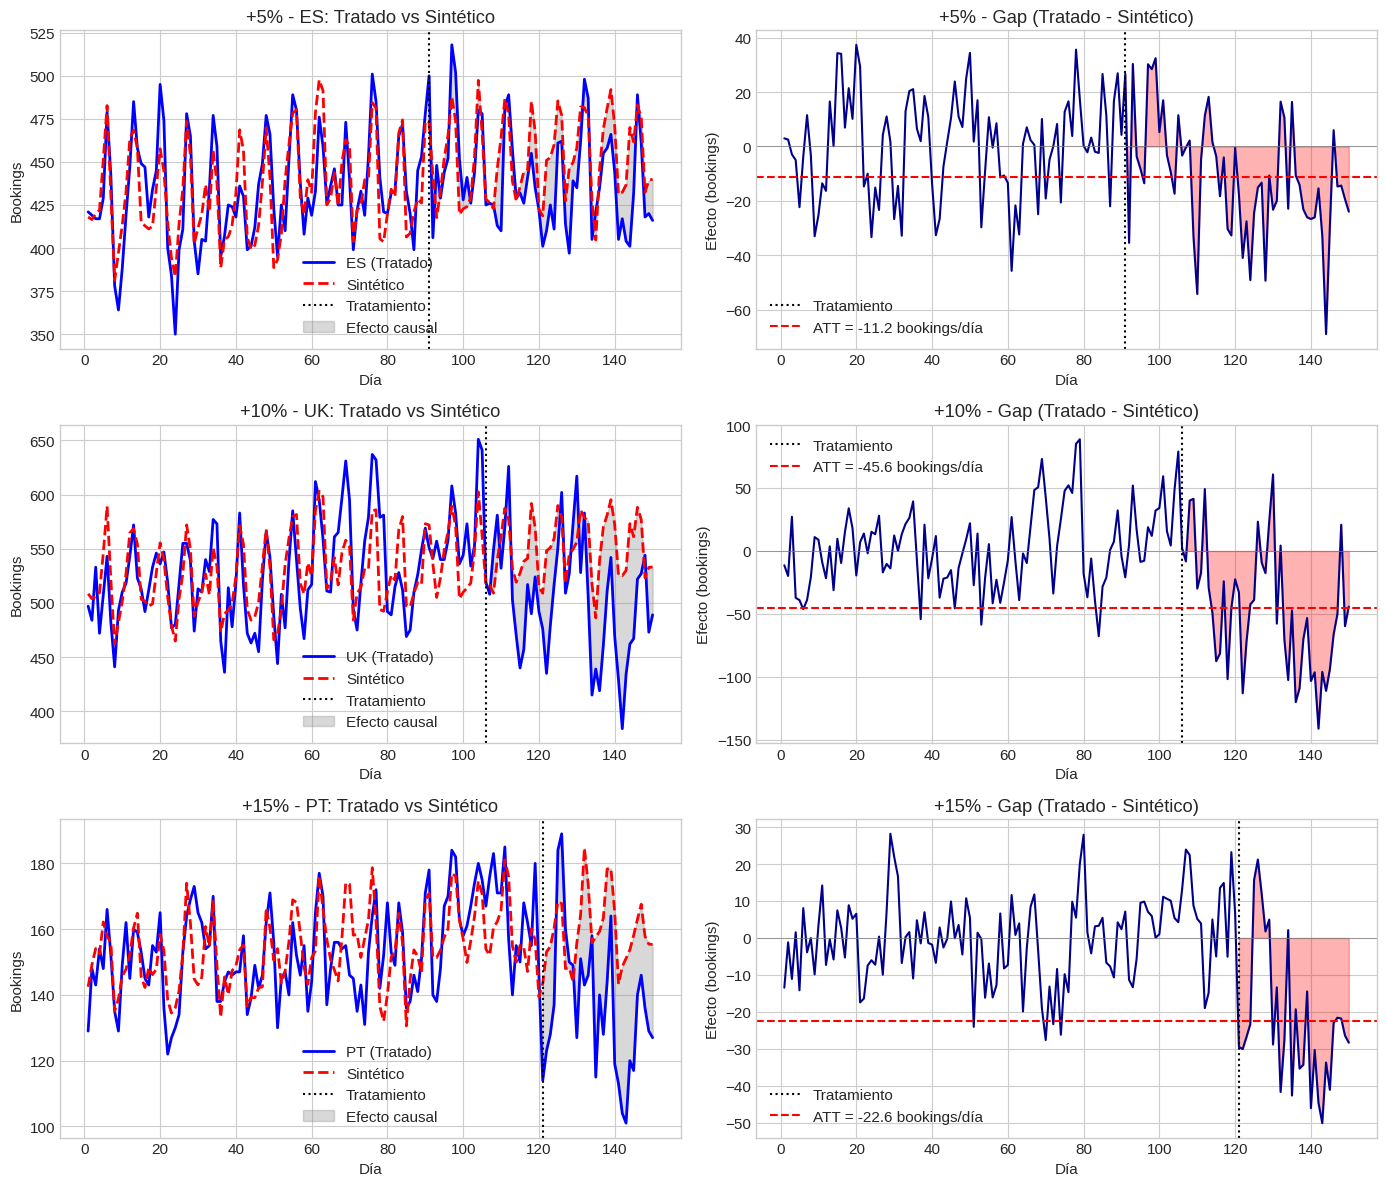

In [10]:
# Visualizar resultados SCM
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for idx, (arm, scm) in enumerate(results.items()):
    t_day = scm['treatment_day']
    day_idx = scm['day_index']

    # Panel izquierdo: Series temporales
    ax = axes[idx, 0]
    ax.plot(day_idx, scm['treated'], label=f'{scm["market"]} (Tratado)', color='blue', linewidth=2)
    ax.plot(day_idx, scm['synthetic'], label='Sintético', color='red', linestyle='--', linewidth=2)
    ax.axvline(x=t_day, color='black', linestyle=':', label='Tratamiento')
    ax.fill_between(day_idx[day_idx >= t_day],
                    scm['treated'][day_idx >= t_day],
                    scm['synthetic'][day_idx >= t_day],
                    alpha=0.3, color='gray', label='Efecto causal')
    ax.set_title(f'{arm} - {scm["market"]}: Tratado vs Sintético')
    ax.set_xlabel('Día')
    ax.set_ylabel('Bookings')
    ax.legend(loc='best')

    # Panel derecho: Gap (efecto)
    ax = axes[idx, 1]
    ax.plot(day_idx, scm['effect'], color='darkblue', linewidth=1.5)
    ax.axvline(x=t_day, color='black', linestyle=':', label='Tratamiento')
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax.fill_between(day_idx, 0, scm['effect'],
                    where=(day_idx >= t_day),
                    alpha=0.3, color='red')

    att = np.mean(scm['effect'][day_idx >= t_day])
    ax.axhline(y=att, color='red', linestyle='--',
               label=f'ATT = {att:.1f} bookings/día')

    ax.set_title(f'{arm} - Gap (Tratado - Sintético)')
    ax.set_xlabel('Día')
    ax.set_ylabel('Efecto (bookings)')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

---

## 9. Validación: Placebo Tests e Inferencia

### 9.1 El problema de inferencia en SCM

Con Synthetic Control, no tenemos errores estándar tradicionales. Usamos **placebo tests** (Abadie et al., 2010):

1. Aplicamos SCM a cada mercado de control como si fuera tratado
2. Comparamos el efecto estimado del tratado real vs. los efectos "placebo"
3. Si el efecto real es extremo respecto a los placebos, es significativo

**Limitación importante**: Con solo 5 mercados de control, el p-value mínimo posible es 1/6 ≈ 0.167.

In [11]:
def run_placebo_test(df, treated_market, control_markets, treatment_day):
    """Ejecuta placebo-in-space: SCM para cada control como si fuera tratado."""
    placebo_effects = {}
    placebo_rmspe = {}

    real_scm = compute_synthetic_control(df, treated_market, control_markets, treatment_day)

    for placebo_market in control_markets:
        other_controls = [m for m in control_markets if m != placebo_market]

        try:
            placebo_scm = compute_synthetic_control(
                df, placebo_market, other_controls, treatment_day
            )
            placebo_effects[placebo_market] = placebo_scm['effect']
            placebo_rmspe[placebo_market] = placebo_scm['rmspe_pre']
        except:
            continue

    return {
        'treated': treated_market,
        'real_effect': real_scm['effect'],
        'real_rmspe': real_scm['rmspe_pre'],
        'placebo_effects': placebo_effects,
        'placebo_rmspe': placebo_rmspe,
        'day_index': real_scm['day_index'],
        'treatment_day': treatment_day
    }

# Ejecutar placebo tests
placebo_results = {}

for arm, info in TREATED_MARKETS.items():
    rep = info['representative']
    t_day = info['treatment_day']

    print(f"Ejecutando placebo test para {rep} ({arm})...")
    placebo_results[arm] = run_placebo_test(df, rep, CONTROL_MARKETS, t_day)

print("\nPlacebo tests completados.")

Ejecutando placebo test para ES (+5%)...
Ejecutando placebo test para UK (+10%)...
Ejecutando placebo test para PT (+15%)...

Placebo tests completados.


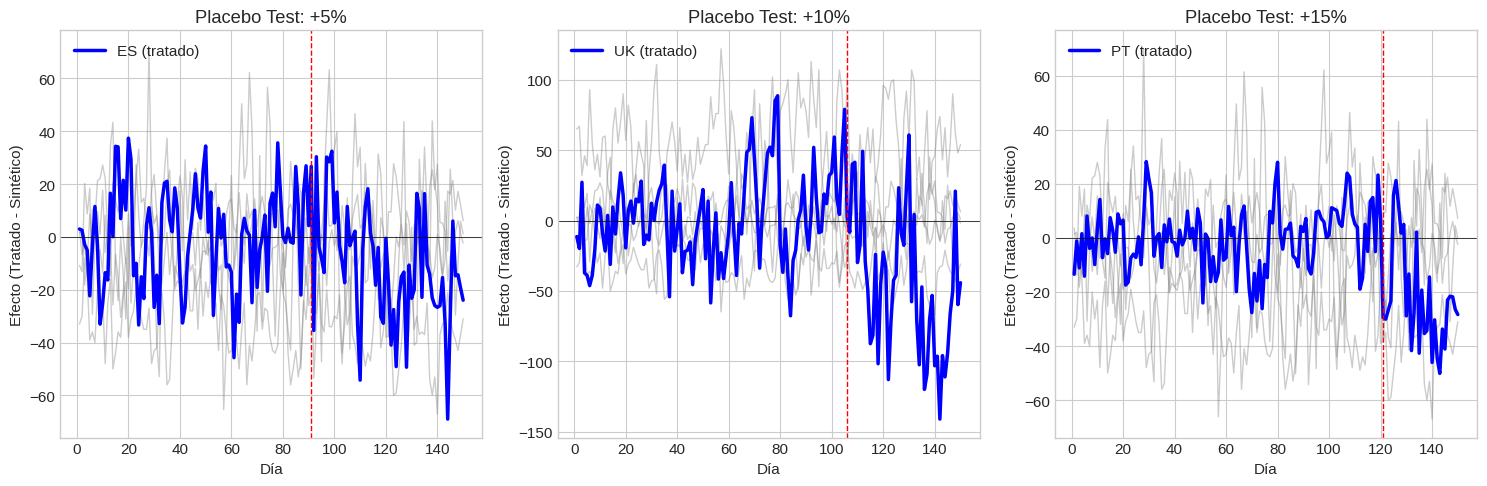

In [12]:
# Visualizar placebo tests
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (arm, placebo) in enumerate(placebo_results.items()):
    ax = axes[idx]
    t_day = placebo['treatment_day']
    day_idx = placebo['day_index']

    for market, effect in placebo['placebo_effects'].items():
        if placebo['placebo_rmspe'][market] < placebo['real_rmspe'] * 3:
            ax.plot(day_idx, effect, color='gray', alpha=0.4, linewidth=1)

    ax.plot(day_idx, placebo['real_effect'], color='blue', linewidth=2.5,
            label=f'{placebo["treated"]} (tratado)')

    ax.axvline(x=t_day, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    ax.set_title(f'Placebo Test: {arm}')
    ax.set_xlabel('Día')
    ax.set_ylabel('Efecto (Tratado - Sintético)')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

---

## 10. Resultados: De ATT a Elasticidad

### Cálculo de elasticidad

La elasticidad precio-demanda se calcula como:

```
ε = %ΔQ / %ΔP
```

**Importante**: Calculamos la elasticidad para cada brazo individualmente, luego promediamos. La elasticidad NO es la pendiente de una regresión de %ΔQ vs %ΔP.

In [13]:
# Calcular ATT y elasticidad para cada brazo
print("RESULTADOS FINALES: ATT Y ELASTICIDAD")
print("="*70)

elasticity_data = []

for arm, scm in results.items():
    t_day = scm['treatment_day']
    market = scm['market']

    # Obtener datos del mercado para calcular ΔP realizado
    market_data = df[df['market'] == market].sort_values('day_index')
    pre_mask_data = market_data['day_index'] < t_day
    post_mask_data = market_data['day_index'] >= t_day

    # ΔP REALIZADO (no nominal) - First Stage
    price_pre = market_data.loc[pre_mask_data, 'price_eur'].mean()
    price_post = market_data.loc[post_mask_data, 'price_eur'].mean()
    pct_change_p = ((price_post - price_pre) / price_pre) * 100

    # ATT: promedio del efecto post-tratamiento
    post_mask = scm['day_index'] >= t_day
    att = np.mean(scm['effect'][post_mask])
    att_std = np.std(scm['effect'][post_mask])

    # Baseline: contrafactual sintético en post-periodo
    pre_mask = scm['day_index'] < t_day
    baseline_synthetic = np.mean(scm['synthetic'][post_mask])
    baseline_treated_pre = np.mean(scm['treated'][pre_mask])

    # Cambio porcentual en bookings (causal)
    pct_change_q = (att / baseline_synthetic) * 100

    # Elasticidad: %ΔQ / %ΔP
    elasticity = pct_change_q / pct_change_p

    elasticity_data.append({
        'arm': arm,
        'market': market,
        'price_change_realized': pct_change_p,
        'att': att,
        'att_std': att_std,
        'baseline_pre': baseline_treated_pre,
        'baseline_cf': baseline_synthetic,
        'pct_change_q': pct_change_q,
        'elasticity': elasticity,
        'rmspe_pre': scm['rmspe_pre']
    })

    print(f"\n{arm} ({market}):")
    print(f"  Baseline pre-tratamiento: {baseline_treated_pre:.0f} bookings/día")
    print(f"  Contrafactual (sintético): {baseline_synthetic:.0f} bookings/día")
    print(f"  ATT: {att:.1f} ± {att_std:.1f} bookings/día")
    print(f"  Cambio en precio (realizado): +{pct_change_p:.1f}%")
    print(f"  Cambio en bookings (causal): {pct_change_q:.1f}%")
    print(f"  Elasticidad precio-demanda: {elasticity:.2f}")

elasticity_df = pd.DataFrame(elasticity_data)

RESULTADOS FINALES: ATT Y ELASTICIDAD

+5% (ES):
  Baseline pre-tratamiento: 433 bookings/día
  Contrafactual (sintético): 452 bookings/día
  ATT: -11.2 ± 21.7 bookings/día
  Cambio en precio (realizado): +5.0%
  Cambio en bookings (causal): -2.5%
  Elasticidad precio-demanda: -0.49

+10% (UK):
  Baseline pre-tratamiento: 530 bookings/día
  Contrafactual (sintético): 549 bookings/día
  ATT: -45.6 ± 49.5 bookings/día
  Cambio en precio (realizado): +10.0%
  Cambio en bookings (causal): -8.3%
  Elasticidad precio-demanda: -0.83

+15% (PT):
  Baseline pre-tratamiento: 154 bookings/día
  Contrafactual (sintético): 159 bookings/día
  ATT: -22.6 ± 18.6 bookings/día
  Cambio en precio (realizado): +15.0%
  Cambio en bookings (causal): -14.2%
  Elasticidad precio-demanda: -0.94


In [14]:
# Tabla resumen final
print("\n" + "="*70)
print("TABLA RESUMEN")
print("="*70)

summary = elasticity_df[['arm', 'market', 'price_change_realized', 'att', 'pct_change_q', 'elasticity', 'rmspe_pre']].copy()
summary.columns = ['Brazo', 'Mercado', 'ΔP Realizado (%)', 'ATT (book/día)', 'ΔQ Causal (%)', 'Elasticidad', 'RMSPE Pre']
print(summary.round(2).to_string(index=False))

# Elasticidad global: promedio ponderado por calidad (1/RMSPE)
# NOTA: NO usamos regresión porque la pendiente de %ΔQ ~ %ΔP NO es la elasticidad
# La elasticidad es %ΔQ / %ΔP para cada punto

print(f"\n" + "-"*70)
print("ESTIMACIÓN DE ELASTICIDAD GLOBAL")
print("-"*70)

# Promedio simple
elasticity_simple = elasticity_df['elasticity'].mean()

# Promedio ponderado por calidad (1/RMSPE) - da más peso a estimaciones con mejor ajuste
weights_quality = 1 / elasticity_df['rmspe_pre']
weights_quality = weights_quality / weights_quality.sum()
elasticity_weighted = (elasticity_df['elasticity'] * weights_quality).sum()

# Promedio ponderado por volumen (baseline)
weights_volume = elasticity_df['baseline_pre']
weights_volume = weights_volume / weights_volume.sum()
elasticity_volume = (elasticity_df['elasticity'] * weights_volume).sum()

print(f"  Elasticidades individuales:")
for _, row in elasticity_df.iterrows():
    print(f"    {row['arm']} ({row['market']}): ε = {row['elasticity']:.2f}")

print(f"\n  Promedio simple: {elasticity_simple:.3f}")
print(f"  Promedio ponderado por calidad (1/RMSPE): {elasticity_weighted:.3f}")
print(f"  Promedio ponderado por volumen: {elasticity_volume:.3f}")

# Usar el promedio ponderado por calidad como estimación principal
elasticity_global = elasticity_weighted

print(f"\n  → Elasticidad global estimada: {elasticity_global:.2f}")
print(f"\n→ Interpretación: Un aumento del 1% en precio reduce los bookings en ~{abs(elasticity_global):.1f}%")

if abs(elasticity_global) < 1:
    print("→ Demanda INELÁSTICA: subir precio AUMENTA revenue")
else:
    print("→ Demanda ELÁSTICA: subir precio REDUCE revenue")


TABLA RESUMEN
Brazo Mercado  ΔP Realizado (%)  ATT (book/día)  ΔQ Causal (%)  Elasticidad  RMSPE Pre
  +5%      ES               5.0          -11.19          -2.47        -0.49      18.39
 +10%      UK              10.0          -45.57          -8.30        -0.83      31.48
 +15%      PT              15.0          -22.56         -14.16        -0.94      11.21

----------------------------------------------------------------------
ESTIMACIÓN DE ELASTICIDAD GLOBAL
----------------------------------------------------------------------
  Elasticidades individuales:
    +5% (ES): ε = -0.49
    +10% (UK): ε = -0.83
    +15% (PT): ε = -0.94

  Promedio simple: -0.756
  Promedio ponderado por calidad (1/RMSPE): -0.784
  Promedio ponderado por volumen: -0.716

  → Elasticidad global estimada: -0.78

→ Interpretación: Un aumento del 1% en precio reduce los bookings en ~0.8%
→ Demanda INELÁSTICA: subir precio AUMENTA revenue


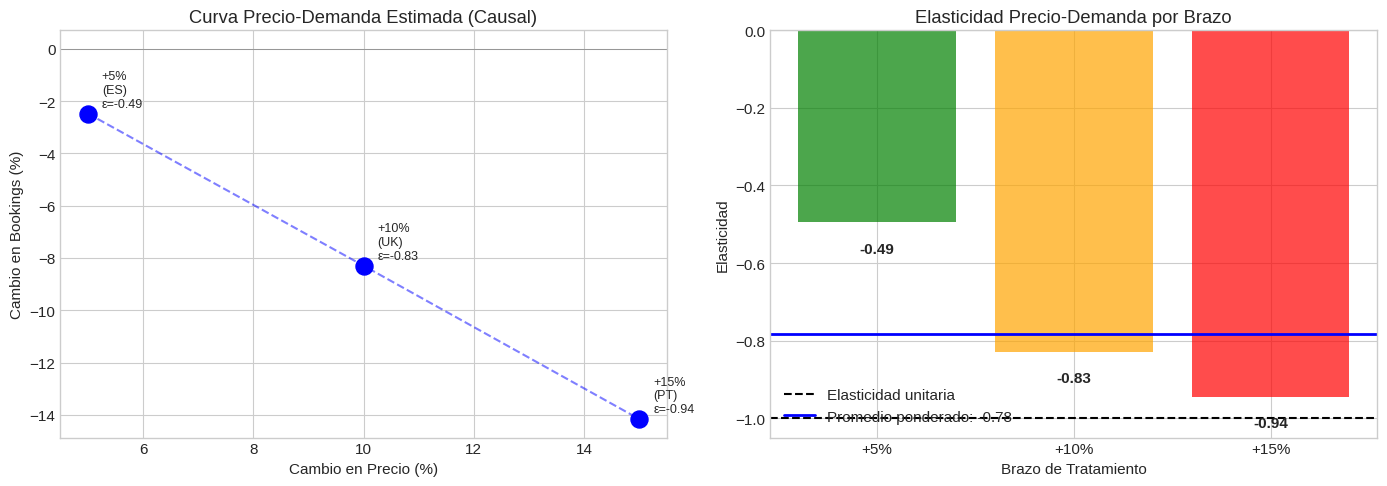

In [15]:
# Visualización de la curva de elasticidad
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Relación Precio-Demanda
ax = axes[0]
ax.scatter(elasticity_df['price_change_realized'], elasticity_df['pct_change_q'],
           s=150, color='blue', zorder=5)
ax.plot(elasticity_df['price_change_realized'], elasticity_df['pct_change_q'],
        '--', color='blue', alpha=0.5)

for _, row in elasticity_df.iterrows():
    ax.annotate(f"{row['arm']}\n({row['market']})\nε={row['elasticity']:.2f}",
                (row['price_change_realized'], row['pct_change_q']),
                textcoords="offset points", xytext=(10, 5), fontsize=9)

ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('Cambio en Precio (%)')
ax.set_ylabel('Cambio en Bookings (%)')
ax.set_title('Curva Precio-Demanda Estimada (Causal)')

# Panel 2: Elasticidad por brazo
ax = axes[1]
colors = ['green', 'orange', 'red']
bars = ax.bar(elasticity_df['arm'], elasticity_df['elasticity'], color=colors, alpha=0.7)
ax.axhline(y=-1, color='black', linestyle='--', label='Elasticidad unitaria')
ax.axhline(y=elasticity_global, color='blue', linestyle='-', linewidth=2,
           label=f'Promedio ponderado: {elasticity_global:.2f}')
ax.set_xlabel('Brazo de Tratamiento')
ax.set_ylabel('Elasticidad')
ax.set_title('Elasticidad Precio-Demanda por Brazo')
ax.legend()

for bar, e in zip(bars, elasticity_df['elasticity']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
            f'{e:.2f}', ha='center', va='top', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

---

## 11. Análisis de Impacto en Revenue

### La pregunta clave para el negocio

```
Revenue = Precio × Cantidad
```

Si la demanda es **inelástica** (|ε| < 1): subir precio → revenue SUBE

Si la demanda es **elástica** (|ε| > 1): subir precio → revenue BAJA

In [16]:
# Calcular impacto en revenue usando el contrafactual sintético
print("="*70)
print("ANÁLISIS DE IMPACTO EN REVENUE")
print("="*70)

revenue_analysis = []

for arm, info in TREATED_MARKETS.items():
    market = info['representative']
    t_day = info['treatment_day']
    scm_result = results[arm]

    price_base = df['base_price_eur'].iloc[0]
    price_new = price_base * (1 + float(arm.replace('%','').replace('+',''))/100)

    market_data = df[df['market'] == market].copy()
    market_data = market_data.sort_values('day_index').reset_index(drop=True)

    synthetic_series = scm_result['synthetic']
    post_indices = market_data['day_index'] >= t_day

    bookings_observed = market_data.loc[post_indices, 'bookings'].mean()
    bookings_synthetic = synthetic_series[post_indices.values].mean()

    revenue_observed = bookings_observed * price_new
    revenue_counterfactual = bookings_synthetic * price_base

    delta_revenue = revenue_observed - revenue_counterfactual
    pct_delta_revenue = (delta_revenue / revenue_counterfactual) * 100

    n_days_post = post_indices.sum()
    total_delta_revenue = delta_revenue * n_days_post

    revenue_analysis.append({
        'arm': arm,
        'market': market,
        'price_base': price_base,
        'price_new': price_new,
        'bookings_obs': bookings_observed,
        'bookings_cf': bookings_synthetic,
        'revenue_obs': revenue_observed,
        'revenue_cf': revenue_counterfactual,
        'delta_revenue_daily': delta_revenue,
        'pct_delta_revenue': pct_delta_revenue,
        'n_days': n_days_post,
        'total_delta_revenue': total_delta_revenue
    })

    print(f"\n{arm} ({market}):")
    print(f"  Precio: {price_base:.0f} EUR → {price_new:.0f} EUR ({arm})")
    print(f"  Bookings observados:     {bookings_observed:.0f}/día")
    print(f"  Bookings contrafactual:  {bookings_synthetic:.0f}/día (sintético)")
    print(f"  Revenue observado:       {revenue_observed:,.0f} EUR/día")
    print(f"  Revenue contrafactual:   {revenue_counterfactual:,.0f} EUR/día")
    print(f"  Delta Revenue:           {delta_revenue:+,.0f} EUR/día ({pct_delta_revenue:+.1f}%)")
    print(f"  Impacto total ({n_days_post} días): {total_delta_revenue:+,.0f} EUR")

revenue_df = pd.DataFrame(revenue_analysis)

ANÁLISIS DE IMPACTO EN REVENUE

+5% (ES):
  Precio: 89 EUR → 93 EUR (+5%)
  Bookings observados:     441/día
  Bookings contrafactual:  452/día (sintético)
  Revenue observado:       41,218 EUR/día
  Revenue contrafactual:   40,251 EUR/día
  Delta Revenue:           +967 EUR/día (+2.4%)
  Impacto total (60 días): +58,016 EUR

+10% (UK):
  Precio: 89 EUR → 98 EUR (+10%)
  Bookings observados:     504/día
  Bookings contrafactual:  549/día (sintético)
  Revenue observado:       49,313 EUR/día
  Revenue contrafactual:   48,886 EUR/día
  Delta Revenue:           +428 EUR/día (+0.9%)
  Impacto total (45 días): +19,248 EUR

+15% (PT):
  Precio: 89 EUR → 102 EUR (+15%)
  Bookings observados:     137/día
  Bookings contrafactual:  159/día (sintético)
  Revenue observado:       13,995 EUR/día
  Revenue contrafactual:   14,177 EUR/día
  Delta Revenue:           -182 EUR/día (-1.3%)
  Impacto total (30 días): -5,470 EUR


---

## 12. Análisis de Guardrails

Monitoreamos métricas de protección:
- **LTV (Lifetime Value)**
- **Churn Rate**
- **CR Checkout→Sale**

In [17]:
# Análisis de Guardrails
print("="*70)
print("ANÁLISIS DE GUARDRAILS")
print("="*70)

guardrail_metrics = ['ltv_eur', 'churn_rate', 'cr_checkout_to_sale']
guardrail_names = {'ltv_eur': 'LTV (EUR)', 'churn_rate': 'Churn Rate', 'cr_checkout_to_sale': 'CR Checkout→Sale'}

guardrail_results = []

for arm, info in TREATED_MARKETS.items():
    market = info['representative']
    t_day = info['treatment_day']

    print(f"\n{arm} ({market}):")
    print("-" * 40)

    for metric in guardrail_metrics:
        try:
            scm_guard = compute_synthetic_control(
                df=df,
                treated_market=market,
                control_markets=CONTROL_MARKETS,
                treatment_day=t_day,
                outcome=metric
            )

            post_mask = scm_guard['day_index'] >= t_day
            att_guard = np.mean(scm_guard['effect'][post_mask])
            baseline_guard = np.mean(scm_guard['synthetic'][post_mask])
            pct_change_guard = (att_guard / baseline_guard) * 100 if baseline_guard != 0 else 0

            is_concerning = False
            if metric == 'ltv_eur' and pct_change_guard < -5:
                is_concerning = True
            elif metric == 'churn_rate' and pct_change_guard > 10:
                is_concerning = True
            elif metric == 'cr_checkout_to_sale' and pct_change_guard < -10:
                is_concerning = True

            status = "⚠️ REVISAR" if is_concerning else "✓ OK"
            print(f"  {guardrail_names[metric]}: {pct_change_guard:+.1f}% {status}")

            guardrail_results.append({
                'arm': arm,
                'market': market,
                'metric': metric,
                'pct_change': pct_change_guard,
                'status': 'concerning' if is_concerning else 'ok'
            })
        except:
            print(f"  {guardrail_names[metric]}: No calculable")

guardrails_df = pd.DataFrame(guardrail_results)

print("\n" + "="*70)
print("RESUMEN GUARDRAILS")
print("="*70)
concerning = guardrails_df[guardrails_df['status'] == 'concerning']
if len(concerning) == 0:
    print("✓ Todos los guardrails dentro de límites aceptables")
else:
    print("⚠️ Guardrails con señales de alerta:")
    for _, row in concerning.iterrows():
        print(f"   - {row['arm']} ({row['market']}): {guardrail_names[row['metric']]} = {row['pct_change']:+.1f}%")

ANÁLISIS DE GUARDRAILS

+5% (ES):
----------------------------------------
  LTV (EUR): -0.2% ✓ OK
  Churn Rate: -0.3% ✓ OK
  CR Checkout→Sale: -1.4% ✓ OK

+10% (UK):
----------------------------------------
  LTV (EUR): -0.1% ✓ OK
  Churn Rate: -0.4% ✓ OK
  CR Checkout→Sale: -2.5% ✓ OK

+15% (PT):
----------------------------------------
  LTV (EUR): +0.5% ✓ OK
  Churn Rate: -5.4% ✓ OK
  CR Checkout→Sale: -3.8% ✓ OK

RESUMEN GUARDRAILS
✓ Todos los guardrails dentro de límites aceptables


---

## 13. Resumen Ejecutivo

In [18]:
# Resumen ejecutivo
print("="*70)
print("RESUMEN EJECUTIVO - EXPERIMENTO DE PRICING")
print("="*70)

print("\n+===================================================================+")
print("|            RESULTADOS DEL EXPERIMENTO DE PRICING                  |")
print("+===================================================================+")

print(f"\n| DISEÑO DEL EXPERIMENTO                                           |")
print(f"|   - Mercados analizados: {len(CONTROL_MARKETS)} controles + 3 tratados              |")
print(f"|   - Periodo: {df['date'].min()} a {df['date'].max()}                        |")
print(f"|   - Metodología: Synthetic Control Method (causal)               |")
print(f"|   - Donor pool: {', '.join(CONTROL_MARKETS)}                                     |")

print("\n+-------------------------------------------------------------------+")
print("| EFECTOS CAUSALES ESTIMADOS (ATT)                                  |")
print("+-------------------------------------------------------------------+")

for _, row in elasticity_df.iterrows():
    arm = row['arm']
    market = row['market']
    att = row['att']
    pct_q = row['pct_change_q']
    print(f"|   {arm:>4} ({market}): ATT = {att:>6.1f} bookings/día ({pct_q:>+5.1f}%)             |")

print("\n+-------------------------------------------------------------------+")
print("| ELASTICIDAD PRECIO-DEMANDA                                        |")
print("+-------------------------------------------------------------------+")
print(f"|                                                                   |")
print(f"|   Elasticidad estimada: {elasticity_global:.2f}                                     |")
print(f"|                                                                   |")
print(f"|   Interpretación:                                                 |")
print(f"|   → Por cada 1% de aumento en precio, la demanda                 |")
print(f"|     disminuye aproximadamente {abs(elasticity_global):.1f}%                              |")
print(f"|                                                                   |")

if abs(elasticity_global) < 1:
    print(f"|   RECOMENDACIÓN:                                                  |")
    print(f"|   La demanda es INELÁSTICA (|ε| < 1). Incrementos moderados       |")
    print(f"|   de precio AUMENTARÍAN el revenue total.                         |")
else:
    print(f"|   ADVERTENCIA:                                                    |")
    print(f"|   La demanda es ELÁSTICA (|ε| > 1). Incrementos de precio         |")
    print(f"|   REDUCIRÍAN el revenue total.                                    |")

print("\n+-------------------------------------------------------------------+")
print("| VALIDACIÓN Y DIAGNÓSTICOS                                         |")
print("+-------------------------------------------------------------------+")
for _, row in elasticity_df.iterrows():
    rmspe = row['rmspe_pre']
    quality = "Excelente" if rmspe < 15 else "Bueno" if rmspe < 25 else "Aceptable"
    print(f"|   {row['market']} ({row['arm']}): RMSPE pre-periodo = {rmspe:.1f} [{quality}]           |")

print("\n+-------------------------------------------------------------------+")
print("| IMPACTO EN REVENUE                                                |")
print("+-------------------------------------------------------------------+")
for _, row in revenue_df.iterrows():
    status = "RENTABLE" if row['pct_delta_revenue'] > 0 else "NEUTRAL" if row['pct_delta_revenue'] > -2 else "PÉRDIDA"
    print(f"|   {row['arm']:>4} ({row['market']}): Revenue {row['pct_delta_revenue']:+.1f}% ({row['total_delta_revenue']:+,.0f} EUR) [{status}]  |")

print("\n+-------------------------------------------------------------------+")
print("| CAVEATS Y LIMITACIONES                                            |")
print("+-------------------------------------------------------------------+")
print("|   - Resultados válidos para mercados similares a ES, UK, PT       |")
print("|   - Efecto estimado a corto plazo (~30-45 días)                   |")
print("|   - Extrapolación a otros mercados requiere validación            |")
print("|   - No captura efectos de largo plazo en marca/lealtad            |")
print("+===================================================================+")

RESUMEN EJECUTIVO - EXPERIMENTO DE PRICING

+===================================================================+
|            RESULTADOS DEL EXPERIMENTO DE PRICING                  |
+===================================================================+

| DISEÑO DEL EXPERIMENTO                                           |
|   - Mercados analizados: 5 controles + 3 tratados              |
|   - Periodo: 2024-01-01 a 2024-05-29                        |
|   - Metodología: Synthetic Control Method (causal)               |
|   - Donor pool: AT, BE, DE, FR, NL                                     |

+-------------------------------------------------------------------+
| EFECTOS CAUSALES ESTIMADOS (ATT)                                  |
+-------------------------------------------------------------------+
|    +5% (ES): ATT =  -11.2 bookings/día ( -2.5%)             |
|   +10% (UK): ATT =  -45.6 bookings/día ( -8.3%)             |
|   +15% (PT): ATT =  -22.6 bookings/día (-14.2%)             

---

## 14. Conclusiones y Limitaciones

### Hallazgos principales

1. **El Synthetic Control Method** permite estimar efectos causales en pricing cuando A/B testing no es viable.

2. **Los diagnósticos son clave**: RMSPE bajo en pre-periodo valida la asunción de aproximabilidad.

3. **Tres puntos permiten estimar la curva**: Con +5%, +10%, +15% caracterizamos la relación precio-demanda.

### Limitaciones

- **Validez local**: Resultados aplican a mercados similares en el periodo analizado
- **Corto plazo**: Efectos de largo plazo en marca/lealtad no capturados
- **Pocos controles**: Con 5 mercados, inferencia estadística tiene poder limitado

---

## Referencias

1. **Hernán, M. A., & Robins, J. M.** (2020). *Causal Inference: What If*. Chapman & Hall/CRC.

2. **Abadie, A., Diamond, A., & Hainmueller, J.** (2010). Synthetic control methods for comparative case studies. *JASA*, 105(490), 493-505.

3. **Abadie, A.** (2021). Using synthetic controls: Feasibility, data requirements, and methodological aspects. *JEL*, 59(2), 391-425.

4. **Facure, M.** (2022). *Causal Inference for the Brave and True*.

---

*Notebook creado siguiendo principios de inferencia causal rigurosa para experimentación en pricing.*